# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [1]:
%pip install sentence-transformers
%pip install faiss-cpu
%pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 850.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [3]:
# We define the directory where the data is located
from google.colab import drive
drive.mount('/content/drive')
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/Fintech//Data"
os.chdir(DIR)

Mounted at /content/drive


In [4]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.

We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [5]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'],
        'TICKER': row['TICKER'],
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [8]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [9]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [10]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [11]:
# Sample 100 distinct news articles
df_news_sample = df_news.sample(n=100, random_state=42)

# Displaying new DataFrame
display(df_news_sample.head())
print(df_news_sample.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
427,ANET,"Broadcom, Arista Networks initiated: Wall Stre...","Broadcom, Arista Networks initiated: Wall Stre...",2025-05-28,The Fly,https://finance.yahoo.com/news/broadcom-arista...,"Broadcom, Arista Networks initiated: Wall Stre..."
1600,EMR,Investors Heavily Search Emerson Electric Co. ...,Emerson Electric (EMR) has received quite a bi...,2025-05-12,Zacks,https://finance.yahoo.com/news/investors-heavi...,Investors Heavily Search Emerson Electric Co. ...
728,BXP,Why Is Ventas (VTR) Down 2.1% Since Last Earni...,Ventas (VTR) reported earnings 30 days ago. Wh...,2025-05-30,Zacks,https://finance.yahoo.com/news/why-ventas-vtr-...,Why Is Ventas (VTR) Down 2.1% Since Last Earni...
3769,QCOM,3 things Nvidia investors should look out for ...,Nvidia's earnings call this week will be a mar...,2025-05-28,Yahoo Finance,https://finance.yahoo.com/news/3-things-nvidia...,3 things Nvidia investors should look out for ...
2711,KR,Inflation-weary Americans queue for toilet pap...,Inflation-scarred American consumers are putti...,2025-05-29,Financial Times,https://finance.yahoo.com/news/inflation-weary...,Inflation-weary Americans queue for toilet pap...


(100, 7)


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [12]:
from openai import OpenAI
from google.colab import userdata
client = OpenAI(api_key = userdata.get('OPENAI_API_KEY'))

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Write a one-sentence bedtime story about a unicorn."}
    ]
)

print(response.choices[0].message.content)

As the stars twinkled like diamonds in the night sky, a gentle unicorn named Luna spread her shimmering wings and took flight, sprinkling dreams of magic and wonder across the sleeping world below.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset.

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [13]:
prompt = """
Given the news headline provided below,
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

In [14]:
# Initializing an empty list to store the questions and news
news_questions_list = []

# Iterating through the sampled news and generate a question for each
for index, row in df_news_sample.iterrows():
    news_summary = row['SUMMARY']
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini", # Using a cost-effective model for demonstration
            messages=[
                {"role": "system", "content": "You are a helpful assistant that generates questions based on news headlines."},
                {"role": "user", "content": prompt.format(news=news_summary)}
            ]
        )
        question = response.choices[0].message.content.strip()
        news_questions_list.append({'NEWS': news_summary, 'QUESTION': question})
    except Exception as e:
        print(f"Error generating question for news: {news_summary[:50]}... Error: {e}")
        news_questions_list.append({'NEWS': news_summary, 'QUESTION': 'Error generating question'})

# Creating a new DataFrame
df_news_questions = pd.DataFrame(news_questions_list)

# Displaying the new DataFrame
display(df_news_questions.head())
print(df_news_questions.shape)

,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the recent recommendations made by Wa...
1,Emerson Electric (EMR) has received quite a bi...,What recent updates are there regarding Emerso...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent earnings report and future estimat...
3,Nvidia's earnings call this week will be a mar...,What should investors pay attention to during ...
4,Inflation-scarred American consumers are putti...,What are the shopping behaviors of inflation-s...


(100, 2)


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [15]:
def evaluate_rag_without_reranking(df_questions, vector_store, k=5):
    """
    Evaluates RAG performance without reranking.

    Args:
        df_questions (pd.DataFrame): DataFrame with 'NEWS' and 'QUESTION' columns.
        vector_store (FaissVectorStore): The FAISS vector store.
        k (int): The number of top results to retrieve.

    Returns:
        pd.DataFrame: The input DataFrame with a 'NO_RERANKER' column
                      indicating the rank of the correct news or 'not found'.
    """
    ranks = []
    retrieved_results = {}

    for index, row in df_questions.iterrows():
        question = row['QUESTION']
        correct_news = row['NEWS']

        if question not in retrieved_results:
             retrieved_results[question] = vector_store.search(question, k=k)

        # Finding the rank of the correct news in the retrieved results
        rank = 'not found'
        for i, (summary, metadata, similarity) in enumerate(retrieved_results[question]):
            if summary == correct_news:
                rank = i
                break
        ranks.append(rank)

    df_questions['NO_RERANKER'] = ranks
    return df_questions

# Evaluating and add the results to the DataFrame
df_news_questions = evaluate_rag_without_reranking(df_news_questions, faiss_store, k=5)

# Displaying the updated DataFrame with the new column
display(df_news_questions.head())
print(df_news_questions['NO_RERANKER'].value_counts())

,NEWS,QUESTION,NO_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the recent recommendations made by Wa...,0
1,Emerson Electric (EMR) has received quite a bi...,What recent updates are there regarding Emerso...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent earnings report and future estimat...,0
3,Nvidia's earnings call this week will be a mar...,What should investors pay attention to during ...,0
4,Inflation-scarred American consumers are putti...,What are the shopping behaviors of inflation-s...,0


NO_RERANKER
0            90
not found     3
4             3
2             2
3             1
1             1
Name: count, dtype: int64


### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [16]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

[ 9.218913  -4.0780296]


In [17]:
def evaluate_rag_with_reranking(df_questions, vector_store, reranker_model, initial_k=100, final_k=5):
    """
    Evaluates RAG performance with reranking.

    Args:
        df_questions (pd.DataFrame): DataFrame with 'NEWS' and 'QUESTION' columns.
        vector_store (FaissVectorStore): The FAISS vector store.
        reranker_model (CrossEncoder): The CrossEncoder reranker model.
        initial_k (int): The number of initial results to retrieve from the vector store.
        final_k (int): The number of top reranked results to consider.

    Returns:
        pd.DataFrame: The input DataFrame with a 'WITH_RERANKER' column
                      indicating the rank of the correct news in the reranked results or 'not found'.
    """
    ranks = []

    for index, row in df_questions.iterrows():
        question = row['QUESTION']
        correct_news = row['NEWS']

        # 1. Retrieving top initial_k summaries from FAISS
        faiss_results = vector_store.search(question, k=initial_k)
        faiss_summaries = [summary for summary, _, _ in faiss_results]

        if not faiss_summaries:
            ranks.append('not found')
            continue

        # 2. Reranking these summaries using the CrossEncoder model
        sentence_pairs = [[question, summary] for summary in faiss_summaries]
        rerank_scores = reranker_model.predict(sentence_pairs)

        # Combining summaries and scores, then sort by score
        scored_summaries = list(zip(faiss_summaries, rerank_scores))
        scored_summaries = sorted(scored_summaries, key=lambda item: item[1], reverse=True)

        # 3. Getting the top final_k reranked results
        top_reranked_summaries = [summary for summary, score in scored_summaries[:final_k]]

        # 4. Recording the new rank of the correct news
        rank = 'not found'
        if correct_news in top_reranked_summaries:
            rank = top_reranked_summaries.index(correct_news)

        ranks.append(rank)

    df_questions['WITH_RERANKER'] = ranks
    return df_questions

# Assuming the cross-encoder model is already loaded in a variable named 'model' (from a previous cell)
# If not, you would need to load it here:
# from sentence_transformers import CrossEncoder
# reranker_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')

# Evaluating and add the results to the DataFrame
df_news_questions = evaluate_rag_with_reranking(df_news_questions, faiss_store, model, initial_k=100, final_k=5)

# Displaying the updated DataFrame with the new column
display(df_news_questions.head())
print(df_news_questions['WITH_RERANKER'].value_counts())

,NEWS,QUESTION,NO_RERANKER,WITH_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the recent recommendations made by Wa...,0,0
1,Emerson Electric (EMR) has received quite a bi...,What recent updates are there regarding Emerso...,0,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent earnings report and future estimat...,0,0
3,Nvidia's earnings call this week will be a mar...,What should investors pay attention to during ...,0,0
4,Inflation-scarred American consumers are putti...,What are the shopping behaviors of inflation-s...,0,0


WITH_RERANKER
0            94
2             3
3             1
1             1
not found     1
Name: count, dtype: int64


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

In [18]:
# Convert 'not found' to NaN for calculations
df_news_questions_numeric = df_news_questions.replace('not found', np.nan)

# Calculate average position
average_rank_no_reranker = df_news_questions_numeric['NO_RERANKER'].mean()
average_rank_with_reranker = df_news_questions_numeric['WITH_RERANKER'].mean()

print(f"Average position without reranking (excluding 'not found'): {average_rank_no_reranker:.2f}")
print(f"Average position with reranking (excluding 'not found'): {average_rank_with_reranker:.2f}")

# Calculate median position
median_rank_no_reranker = df_news_questions_numeric['NO_RERANKER'].median()
median_rank_with_reranker = df_news_questions_numeric['WITH_RERANKER'].median()

print(f"Median position without reranking (excluding 'not found'): {median_rank_no_reranker:.2f}")
print(f"Median position with reranking (excluding 'not found'): {median_rank_with_reranker:.2f}")


# Calculate frequency at position 0
freq_pos_0_no_reranker = (df_news_questions['NO_RERANKER'] == 0).sum()
freq_pos_0_with_reranker = (df_news_questions['WITH_RERANKER'] == 0).sum()

print(f"\nFrequency at position 0 without reranking: {freq_pos_0_no_reranker}")
print(f"Frequency at position 0 with reranking: {freq_pos_0_with_reranker}")

# Calculate percentage at position 0
total_questions = len(df_news_questions)
perc_pos_0_no_reranker = (freq_pos_0_no_reranker / total_questions) * 100
perc_pos_0_with_reranker = (freq_pos_0_with_reranker / total_questions) * 100

print(f"Percentage at position 0 without reranking: {perc_pos_0_no_reranker:.2f}%")
print(f"Percentage at position 0 with reranking: {perc_pos_0_with_reranker:.2f}%")

# Optional: Value counts for all ranks
print("\nValue counts without reranking:")
print(df_news_questions['NO_RERANKER'].value_counts())

print("\nValue counts with reranking:")
print(df_news_questions['WITH_RERANKER'].value_counts())

Average position without reranking (excluding 'not found'): 0.21
Average position with reranking (excluding 'not found'): 0.10
Median position without reranking (excluding 'not found'): 0.00
Median position with reranking (excluding 'not found'): 0.00

Frequency at position 0 without reranking: 90
Frequency at position 0 with reranking: 94
Percentage at position 0 without reranking: 90.00%
Percentage at position 0 with reranking: 94.00%

Value counts without reranking:
NO_RERANKER
0            90
not found     3
4             3
2             2
3             1
1             1
Name: count, dtype: int64

Value counts with reranking:
WITH_RERANKER
0            94
2             3
3             1
1             1
not found     1
Name: count, dtype: int64


/tmp/ipython-input-2471077979.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_news_questions_numeric = df_news_questions.replace('not found', np.nan)


In [19]:
# Calculate Accuracy (correct news in top 5)
total_questions = len(df_news_questions)
accuracy_no_reranker = (df_news_questions['NO_RERANKER'] != 'not found').sum() / total_questions * 100
accuracy_with_reranker = (df_news_questions['WITH_RERANKER'] != 'not found').sum() / total_questions * 100

# Calculate Coverage (correct news found in top 5)
coverage_no_reranker = accuracy_no_reranker # Based on top 5
coverage_with_reranker = accuracy_with_reranker # Based on top 5 reranked

# Create a summary table
summary_data = {
    'Metric': ['Accuracy (Top 5)', 'Coverage (Top 5)'],
    'Without Reranking': [accuracy_no_reranker, coverage_no_reranker],
    'With Reranking': [accuracy_with_reranker, coverage_with_reranker]
}
df_summary = pd.DataFrame(summary_data)

print("Summary Table:")
display(df_summary)

Summary Table:


,Metric,Without Reranking,With Reranking
0,Accuracy (Top 5),97.0,99.0
1,Coverage (Top 5),97.0,99.0


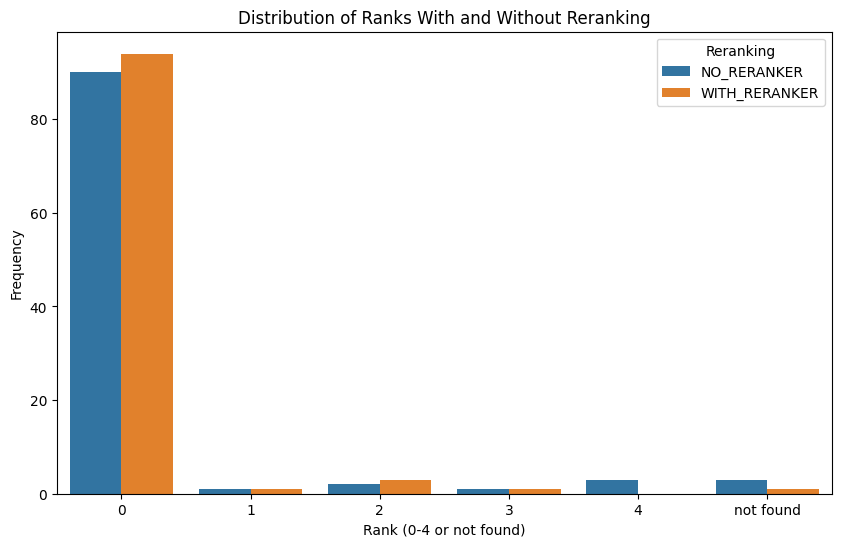

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
rank_counts = df_news_questions.melt(value_vars=['NO_RERANKER', 'WITH_RERANKER'], var_name='Reranking', value_name='Rank')

# Replace 'not found' with a value that will be plotted separately or excluded
# For this plot, let's convert 'not found' to a string to keep it as a separate category
rank_counts['Rank'] = rank_counts['Rank'].astype(str)

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(data=rank_counts, x='Rank', hue='Reranking', order=sorted(rank_counts['Rank'].unique()))
plt.title('Distribution of Ranks With and Without Reranking')
plt.xlabel('Rank (0-4 or not found)')
plt.ylabel('Frequency')
plt.show()

### **Question 1.** Did reranking improve the **average position** of the correct news?


YOUR WRITTEN RESPONSE HERE

* According to the analysis, reranking improved dramatically the average position of the right news. The mean rank, excluding 'not found' cases, decreased from 0.21 without reranking to 0.10 with reranking. This implies the right article was ranked higher on average in the results with the reranking step included as part of the retrieval pipeline. The median rank remained 0.00, meaning that for most of the queries, the right article was already highly ranked regardless, but reranking served to obtain a better ranking when the initial ranking was not optimal.

### **Question 2.** How often was the correct article at **position 0** with and without reranking?


YOUR WRITTEN RESPONSE HERE

* With regard to how frequently the correct article showed up in position 0, without reranking, the correct article showed up in position 0 in 90 of 100 queries, which is a total of 90.00% of the questions it was tested against. When there was reranking, the correct article showing up in position 0 climbed to 94 of 100 queries, or 94.00%. This indicates there was a big boost in ranking the most relevant document as the first on the results list with reranking.